# Create rasters to group data by country, WHO region, Lancet Countdown region, ...

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

from cartopy import crs as ccrs
from scipy import stats
from tqdm.notebook import tqdm
import os
import sys

project_path = os.path.abspath(os.path.join('..', '..'))
if project_path not in sys.path:
    sys.path.insert(0, project_path)

from source.config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC




# Countries

In [4]:
country_polygons = gpd.read_file(DATA_SRC / 'lancet' / 'admin_boundaries' / 'Detailed_Boundary_ADM0' / 'GLOBAL_ADM0.shp')

In [19]:
import geopandas as gpd
from geocube.api.core import make_geocube
import xarray as xr

# Assuming you have defined WEATHER_SRC and country_polygons correctly

# Open one year of ERA5 data to put population data on the same grid
era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")

# Convert longitudes to -180 to 180 range
era5_data = era5_data.assign_coords(longitude=(((era5_data.longitude + 180) % 360) - 180)).sortby('longitude')

# Assuming the ERA5 data is in WGS84 CRS
era5_data.rio.set_crs('EPSG:4326', inplace=True)

# Assuming country_polygons is in WGS84 CRS
country_polygons = country_polygons.to_crs('EPSG:4326')

# Rename dimensions for consistency
era5_data = era5_data.rename({"longitude": "x", "latitude": "y"})

# Select a single time slice, assuming time dimension is present
era5_data = era5_data.isel(time=0)

# Set CRS again after renaming dimensions
era5_data.rio.set_crs('EPSG:4326', inplace=True)

# Create rasterized data using make_geocube
rasterized_data = make_geocube(vector_data=country_polygons, like=era5_data, measurements=['OBJECTID'])
rasterized_data = rasterized_data.rename({'y':'latitude', 'x':'longitude'})

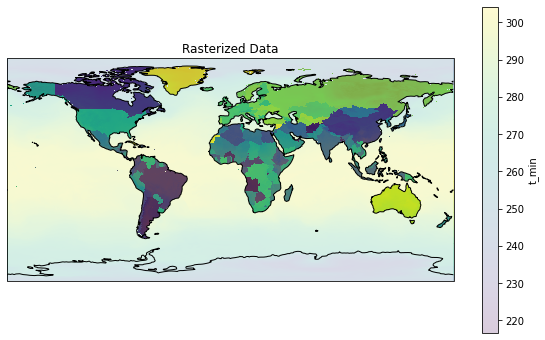

In [20]:
# Plot the rasterized data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
rasterized_data['OBJECTID'].plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree(), add_colorbar=False)
era5_data['t_min'].plot(ax=ax, alpha=0.2, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('Rasterized Data')
plt.show()

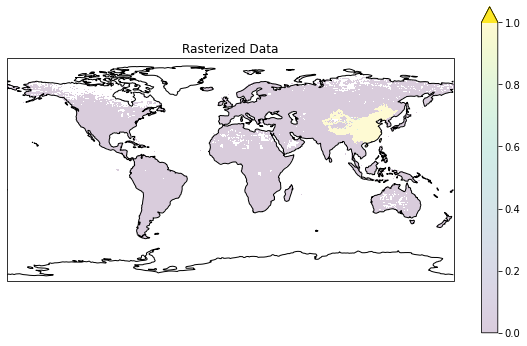

In [21]:
ELDERLY_TOTALS_FILE = POP_DATA_SRC / 'hybrid_2024' / f'worldpop_infants_1950_2023_era5_compatible.nc'

population_elderly = xr.open_dataarray(ELDERLY_TOTALS_FILE)

population_elderly = population_elderly.isel(year=0)
population_elderly = population_elderly.assign_coords(longitude=(((population_elderly.longitude + 180) % 360) - 180)).sortby('longitude')

country_mask = rasterized_data == 41

chn_data = (country_mask['OBJECTID']*population_elderly)

# Plot the rasterized data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
chn_data.plot(ax=ax, alpha=0.2, transform=ccrs.PlateCarree(),vmax=1)
ax.coastlines()
plt.title('Rasterized Data')
plt.show()


In [22]:
rasterized_data

<xarray.Dataset>
Dimensions:      (latitude: 721, longitude: 1440)
Coordinates:
  * latitude     (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude    (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    spatial_ref  int64 0
Data variables:
    OBJECTID     (latitude, longitude) float64 nan nan nan nan ... nan nan nan

In [23]:
era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")

# rasterized_data = rasterized_data.assign_coords(longitude=era5_data.longitude)
rasterized_data.to_netcdf(DATA_SRC / 'lancet' / 'admin_boundaries' / 'admin0_raster_report_2024.nc')

# WHO region

In [25]:
country_polygons

region_to_id = {region: i for i, region in enumerate(country_polygons['WHO_REGION'].unique(), start=1)}
# Apply the mapping to create a new column with numerical identifiers
country_polygons['WHO_REGION_ID'] = country_polygons['WHO_REGION'].map(region_to_id)

In [26]:
import geopandas as gpd
from geocube.api.core import make_geocube
import xarray as xr

# Assuming you have defined WEATHER_SRC and country_polygons correctly

# Open one year of ERA5 data to put population data on the same grid
era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")

# Convert longitudes to -180 to 180 range
era5_data = era5_data.assign_coords(longitude=(((era5_data.longitude + 180) % 360) - 180)).sortby('longitude')

# Assuming the ERA5 data is in WGS84 CRS
era5_data.rio.set_crs('EPSG:4326', inplace=True)

# Assuming country_polygons is in WGS84 CRS
country_polygons = country_polygons.to_crs('EPSG:4326')

# # Rename dimensions for consistency
# era5_data = era5_data.rename({"longitude": "x", "latitude": "y"})

# Select a single time slice, assuming time dimension is present
era5_data = era5_data.isel(time=0)

# Set CRS again after renaming dimensions
era5_data.rio.set_crs('EPSG:4326', inplace=True)

# Create rasterized data using make_geocube
rasterized_data = make_geocube(vector_data=country_polygons, like=era5_data, measurements=['WHO_REGION_ID'])
rasterized_data = rasterized_data.rename({'y':'latitude', 'x':'longitude'})

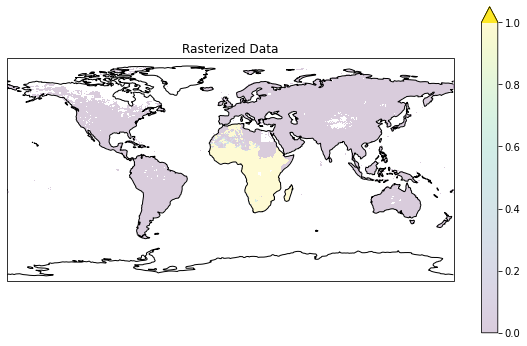

In [29]:
ELDERLY_TOTALS_FILE = POP_DATA_SRC / 'hybrid_2024' / f'worldpop_elderly_1950_2023_era5_compatible.nc'

population_elderly = xr.open_dataarray(ELDERLY_TOTALS_FILE)

population_elderly = population_elderly.isel(year=0)
population_elderly = population_elderly.assign_coords(longitude=(((population_elderly.longitude + 180) % 360) - 180)).sortby('longitude')


reg_mask = rasterized_data == 3

who2_data = (reg_mask['WHO_REGION_ID']*population_elderly)
#who2_data = who2_data.assign_coords(longitude=(((who2_data.longitude + 180) % 360) - 180))

# Plot the rasterized data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
who2_data.plot(ax=ax, alpha=0.2, transform=ccrs.PlateCarree(),vmax=1)
ax.coastlines()
plt.title('Rasterized Data')
plt.show()


In [ ]:
rasterized_data

In [30]:
# era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")

# rasterized_data = rasterized_data.assign_coords(longitude=era5_data.longitude)
rasterized_data.to_netcdf(DATA_SRC / 'lancet' / 'admin_boundaries' / 'WHO_regions_raster_report_2024.nc')

# HDI Raster

In [5]:
country_lc_grouping = pd.read_excel(DATA_SRC / 'lancet' / 'admin_boundaries' /'Country Names and Groupings - 2024 Report.xlsx', header=1)

country_polygons = country_polygons.merge(country_lc_grouping.rename(columns={'ISO3':'ISO_3_CODE'}))

region_to_id = {region: i for i, region in enumerate(country_polygons['HDI Level (2021)'].unique(), start=1)}
# Apply the mapping to create a new column with numerical identifiers
country_polygons['HDI_ID'] = country_polygons['HDI Level (2021)'].map(region_to_id)

In [6]:
import geopandas as gpd
from geocube.api.core import make_geocube
import xarray as xr

# Assuming you have defined WEATHER_SRC and country_polygons correctly

# Open one year of ERA5 data to put population data on the same grid
era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")

# Convert longitudes to -180 to 180 range
era5_data = era5_data.assign_coords(longitude=(((era5_data.longitude + 180) % 360) - 180)).sortby('longitude')

# Assuming the ERA5 data is in WGS84 CRS
era5_data.rio.set_crs('EPSG:4326', inplace=True)

# Assuming country_polygons is in WGS84 CRS
country_polygons = country_polygons.to_crs('EPSG:4326')

# # Rename dimensions for consistency
# era5_data = era5_data.rename({"longitude": "x", "latitude": "y"})

# Select a single time slice, assuming time dimension is present
era5_data = era5_data.isel(time=0)

# Set CRS again after renaming dimensions
era5_data.rio.set_crs('EPSG:4326', inplace=True)

# Create rasterized data using make_geocube
rasterized_data = make_geocube(vector_data=country_polygons, like=era5_data, measurements=['HDI_ID'])
rasterized_data = rasterized_data.rename({'y':'latitude', 'x':'longitude'})

In [7]:
country_polygons[['HDI Level (2021)','HDI_ID']].drop_duplicates()

,HDI Level (2021),HDI_ID
0,NaN,1
1,Low,2
2,Medium,3
4,Very High,4
7,High,5


In [11]:
hdi_regions_previous = xr.open_dataarray(POP_DATA_SRC / 'regions/hdi_regions_15min_era_compat.nc')

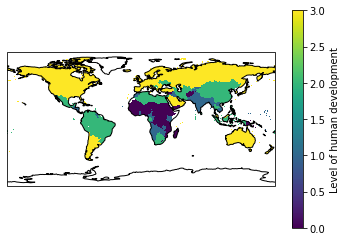

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming your DataArray is named 'data_array'

# Create a figure and axis with PlateCarree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data using pcolormesh
hdi_regions_previous.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add coastlines
ax.coastlines()

# Add a colorbar
#plt.colorbar(label='Level of human development')

# Show the plot
plt.show()


In [14]:
hdi_regions_previous

<xarray.DataArray 'Level of human development' (latitude: 720, longitude: 1440)>
[1036800 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75
Attributes:
    level_of_human_development:  ['Low', 'Medium', 'High', 'Very High']

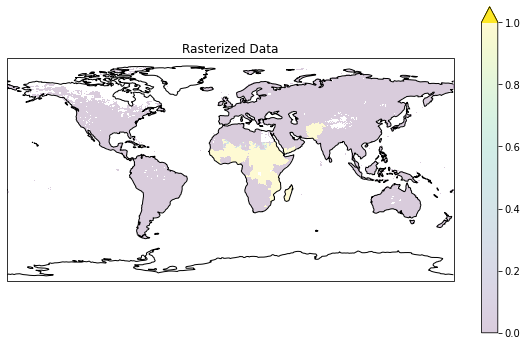

In [21]:
ELDERLY_TOTALS_FILE = POP_DATA_SRC / 'hybrid_2024' / f'worldpop_elderly_1950_2023_era5_compatible.nc'

population_elderly = xr.open_dataarray(ELDERLY_TOTALS_FILE)

population_elderly = population_elderly.isel(year=0)
population_elderly = population_elderly.assign_coords(longitude=(((population_elderly.longitude + 180) % 360) - 180)).sortby('longitude')


reg_mask = rasterized_data == 2

who2_data = (reg_mask['HDI_ID']*population_elderly)
#who2_data = who2_data.assign_coords(longitude=(((who2_data.longitude + 180) % 360) - 180))

# Plot the rasterized data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
who2_data.plot(ax=ax, alpha=0.2, transform=ccrs.PlateCarree(),vmax=1)
ax.coastlines()
plt.title('Rasterized Data')
plt.show()


In [35]:
# era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")
# rasterized_data = rasterized_data.assign_coords(longitude=era5_data.longitude)
rasterized_data.to_netcdf(DATA_SRC / 'lancet' / 'admin_boundaries' / 'HDI_group_raster_report_2024.nc')

In [8]:
hdi_regions_new_raster = xr.open_dataset(DATA_SRC / 'lancet' / 'admin_boundaries' / 'HDI_group_raster_report_2024.nc')

In [12]:
hdi_regions_new_raster

<xarray.Dataset>
Dimensions:      (latitude: 721, longitude: 1440)
Coordinates:
  * latitude     (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude    (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Data variables:
    HDI_ID       (latitude, longitude) float64 ...
    spatial_ref  int64 ...

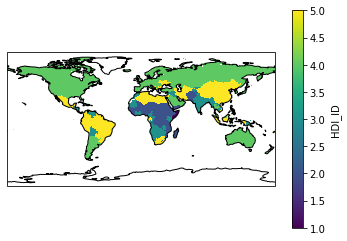

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming your DataArray is named 'data_array'

# Create a figure and axis with PlateCarree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data using pcolormesh
hdi_regions_new_raster['HDI_ID'].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add coastlines
ax.coastlines()

# Add a colorbar
#plt.colorbar(label='Level of human development')

# Show the plot
plt.show()


# Lancet Countdown Raster

In [36]:
region_to_id = {region: i for i, region in enumerate(country_polygons['LC Grouping'].unique(), start=1)}
# Apply the mapping to create a new column with numerical identifiers
country_polygons['LC_GROUPING_ID'] = country_polygons['LC Grouping'].map(region_to_id)


In [37]:
import geopandas as gpd
from geocube.api.core import make_geocube
import xarray as xr

# Assuming you have defined WEATHER_SRC and country_polygons correctly

# Open one year of ERA5 data to put population data on the same grid
era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")

# Convert longitudes to -180 to 180 range
era5_data = era5_data.assign_coords(longitude=(((era5_data.longitude + 180) % 360) - 180)).sortby('longitude')

# Assuming the ERA5 data is in WGS84 CRS
era5_data.rio.set_crs('EPSG:4326', inplace=True)

# Assuming country_polygons is in WGS84 CRS
country_polygons = country_polygons.to_crs('EPSG:4326')

# # Rename dimensions for consistency
# era5_data = era5_data.rename({"longitude": "x", "latitude": "y"})

# Select a single time slice, assuming time dimension is present
era5_data = era5_data.isel(time=0)

# Set CRS again after renaming dimensions
era5_data.rio.set_crs('EPSG:4326', inplace=True)

# Create rasterized data using make_geocube
rasterized_data = make_geocube(vector_data=country_polygons, like=era5_data, measurements=['LC_GROUPING_ID'])
rasterized_data = rasterized_data.rename({'y':'latitude', 'x':'longitude'})

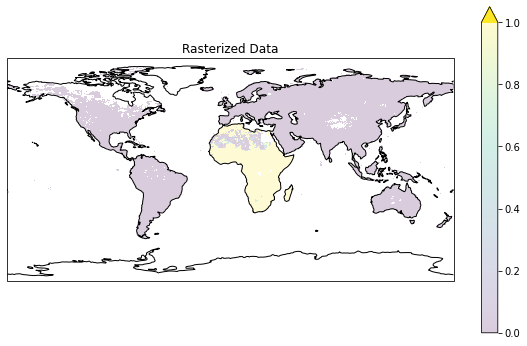

In [38]:
ELDERLY_TOTALS_FILE = POP_DATA_SRC / 'hybrid_2024' / f'worldpop_elderly_1950_2023_era5_compatible.nc'

population_elderly = xr.open_dataarray(ELDERLY_TOTALS_FILE)

population_elderly = population_elderly.isel(year=0)
population_elderly = population_elderly.assign_coords(longitude=(((population_elderly.longitude + 180) % 360) - 180)).sortby('longitude')


reg_mask = rasterized_data == 3

who2_data = (reg_mask['LC_GROUPING_ID']*population_elderly)
#who2_data = who2_data.assign_coords(longitude=(((who2_data.longitude + 180) % 360) - 180))

# Plot the rasterized data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
who2_data.plot(ax=ax, alpha=0.2, transform=ccrs.PlateCarree(),vmax=1)
ax.coastlines()
plt.title('Rasterized Data')
plt.show()


In [39]:
# era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")
# rasterized_data = rasterized_data.assign_coords(longitude=era5_data.longitude)
rasterized_data.to_netcdf(DATA_SRC / 'lancet' / 'admin_boundaries' / 'LC_group_raster_report_2024.nc')

# Admin1

In [ ]:
admin1_polygons = gpd.read_file(DATA_SRC / 'lancet' / 'admin_boundaries' / 'Detailed_Boundary_ADM1' / 'Detailed_Boundary_ADM1.shp')

In [ ]:
import geopandas as gpd
from geocube.api.core import make_geocube
import xarray as xr

# Assuming you have defined WEATHER_SRC and country_polygons correctly

# Open one year of ERA5 data to put population data on the same grid
era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")

# Convert longitudes to -180 to 180 range
era5_data = era5_data.assign_coords(longitude=(((era5_data.longitude + 180) % 360) - 180)).sortby('longitude')

# Assuming the ERA5 data is in WGS84 CRS
era5_data.rio.set_crs('EPSG:4326', inplace=True)

# Assuming country_polygons is in WGS84 CRS
country_polygons = country_polygons.to_crs('EPSG:4326')

# Rename dimensions for consistency
era5_data = era5_data.rename({"longitude": "x", "latitude": "y"})

# Select a single time slice, assuming time dimension is present
era5_data = era5_data.isel(time=0)

# Set CRS again after renaming dimensions
era5_data.rio.set_crs('EPSG:4326', inplace=True)

# Create rasterized data using make_geocube
rasterized_data = make_geocube(vector_data=admin1_polygons, like=era5_data, measurements=['OBJECTID'])
rasterized_data = rasterized_data.rename({'y':'latitude', 'x':'longitude'})

In [ ]:
ELDERLY_TOTALS_FILE = POP_DATA_SRC / 'hybrid_2024' / f'worldpop_infants_1950_2023_era5_compatible.nc'

population_elderly = xr.open_dataarray(ELDERLY_TOTALS_FILE)

population_elderly = population_elderly.isel(year=0)
population_elderly = population_elderly.assign_coords(longitude=(((population_elderly.longitude + 180) % 360) - 180)).sortby('longitude')

country_mask = rasterized_data > 10000

chn_data = (country_mask['OBJECTID']*population_elderly)

# Plot the rasterized data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
chn_data.plot(ax=ax, alpha=0.2, transform=ccrs.PlateCarree(),vmax=1)
ax.coastlines()
plt.title('Rasterized Data')
plt.show()


In [ ]:
# era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")
# rasterized_data = rasterized_data.assign_coords(longitude=era5_data.longitude)
rasterized_data.to_netcdf(DATA_SRC / 'lancet' / 'admin_boundaries' / 'admin1_raster_report_2024.nc')